In [5]:
import warnings
warnings.simplefilter('ignore', UserWarning)

from qdb import QdbApi
q = QdbApi()

from market_timing import MarketTiming

成功连接数据库：user=read_only)
连接Arctic失败：user=None)


In [2]:
mt_model = MarketTiming()

成功连接数据库：user=read_only)
连接Arctic失败：user=None)


In [3]:
def cal_period_perf_indicator(df):
    """
    计算区间业绩指标(高级版)
    Input
        df: 价格或净值序列，DataFrame, index是datetime.date，每列是一只基金
    Output
        ['AnnRet1', 'AnnRet2', 'AnnVol', 'SR', 'MaxDD', 'Calmar'] 
    """

    assert type(df)==pd.DataFrame
    assert type(df.index[0])==dt.date
    
    indicators = ['AnnRet', 'AnnRet_Simple', 'AnnVol', 'SR', 'MaxDD', 'Calmar']
    res = pd.DataFrame(index=df.columns, columns=indicators)
    date_ordinal = pd.Series([dt.date.toordinal(e) for e in df.index])
    time_diff = date_ordinal - date_ordinal.shift(1) # 相对上一次净值的日期间隔
    for col in df:    
        p = df[col] # 单个资产价格或净值序列, pd.Series
        r = p.pct_change() # 涨幅
        annret = (p[-1] / p[0]) ** (365/(p.index[-1]-p.index[0]).days) - 1 # 复利年化收益
        r1 = r.values / time_diff # 日均收益
        annret1 = np.nanmean(r1) * 365 # 单利年化收益
        r2 = r.values / np.sqrt(time_diff) # 波动率调整后涨幅   
        annvol = np.nanstd(r2) * np.sqrt(365) # 年化波动率
        sr = (annret - 0.025) / annvol # 夏普比率
        mdd = np.min(p/p.cummax() - 1) # 最大回撤
        calmar = annret / -mdd
        res.loc[col] = [annret, annret1, annvol, sr, mdd, calmar]

    return res

## 样例指标：北向资金净买入

$$
X_t:= NorthCap(t_i)
$$

使用过去50个交易日作为滑动窗口进行Z-score标准化，得到最终输入信号$fcst$
$$
fcst = \{fcst_t,\ t\in T\}:= \{f(X_t),\ t\in T\}
= \left\{ \frac{X_t - \bar{x}_t}{\sigma_{t}}, t\in T \right\}
$$
$\bar{x}_t$和$\sigma_{t}$为过去50个交易日$[t-49, t]$的均值和标准差

In [4]:
start_date = mt_model.start_date
end_date = mt_model.end_date

north_cap_sgn = mt_model.get_macro_data(macro_ids=["north_cap"], 
                                        start_date=start_date, 
                                        end_date=end_date).set_index("data_date")["value_"]

mt_model.signal(north_cap_sgn)

对择时信号进行滑动窗口标准化，winndow_size = 50
得到预测序列fcst
count    895.000000
mean       0.019314
std        1.054064
min       -4.699969
25%       -0.586825
50%        0.011665
75%        0.610377
max        4.745678
Name: fcst, dtype: float64


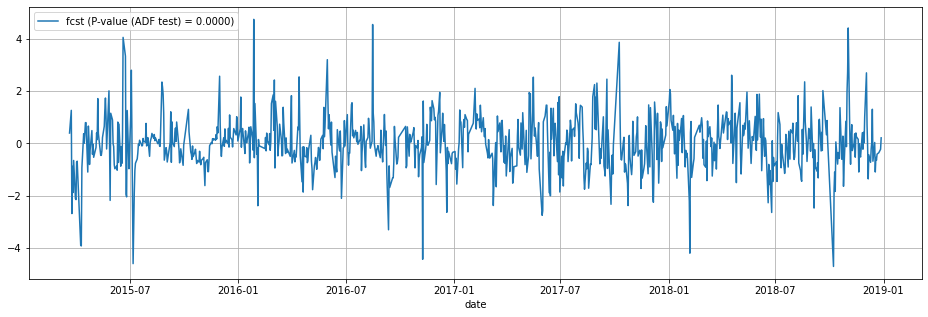

In [5]:
mt_model.plot_fcst()

## 内积评估
定义
$$ret(t+h) = \left.\left (\frac{Close(t+h)}{Open(t+1)} - 1\right )\right/ h $$
表示未来$h$天股指的平均日涨跌幅和
$$ret(t+h_1, t+h_2) = \left.\left(\frac{Close(t+h_2)}{Open(t+h_1)} - 1\right)\right/ (h_2-h_1+1)$$
表示从未来$h_1$天到未来$h_2$天股指的涨跌幅。再使用不同的时间期限分别计算内积
$$
fcst^T \cdot [ ret_{1}, ret_{5}, ret_{10}, ret_{21}, ret_{63} ]
$$
和
$$
fcst^T \cdot [ ret_{1}, ret_{2, 5}, ret_{6, 10}, ret_{11, 21}, ret_{22, 63} ]
$$
生成累积的内积序列，分别作图比较

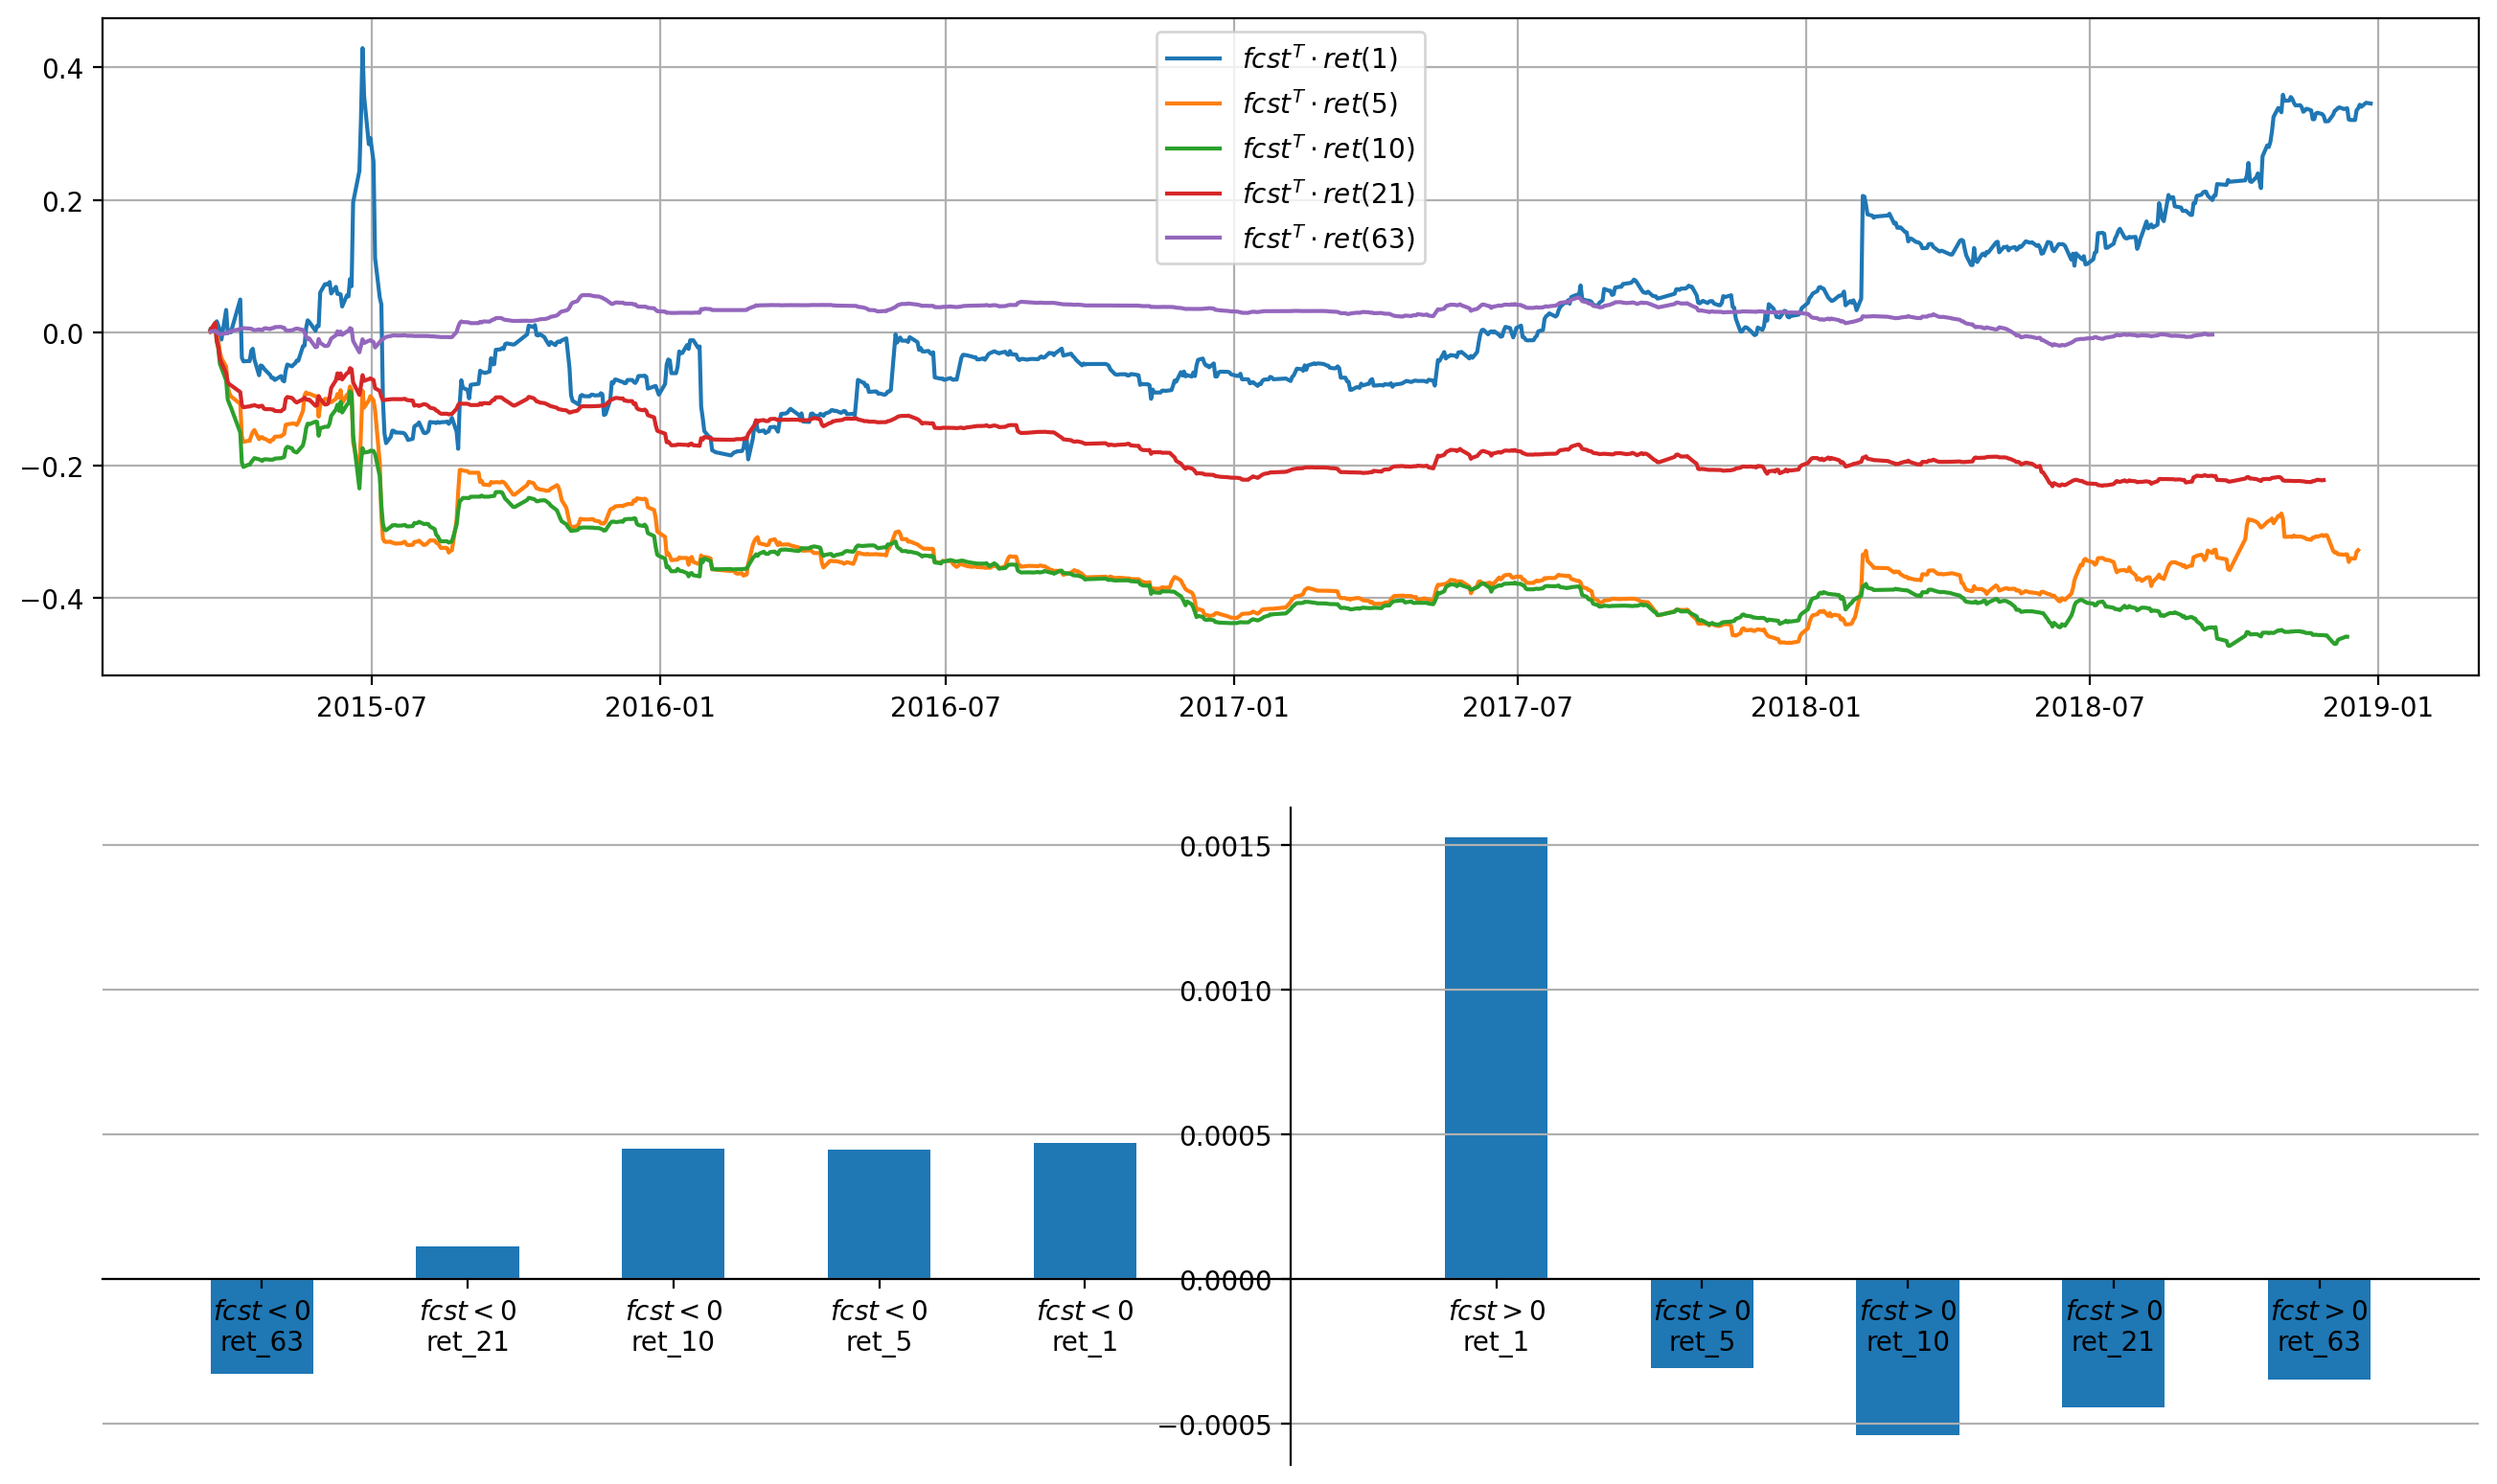

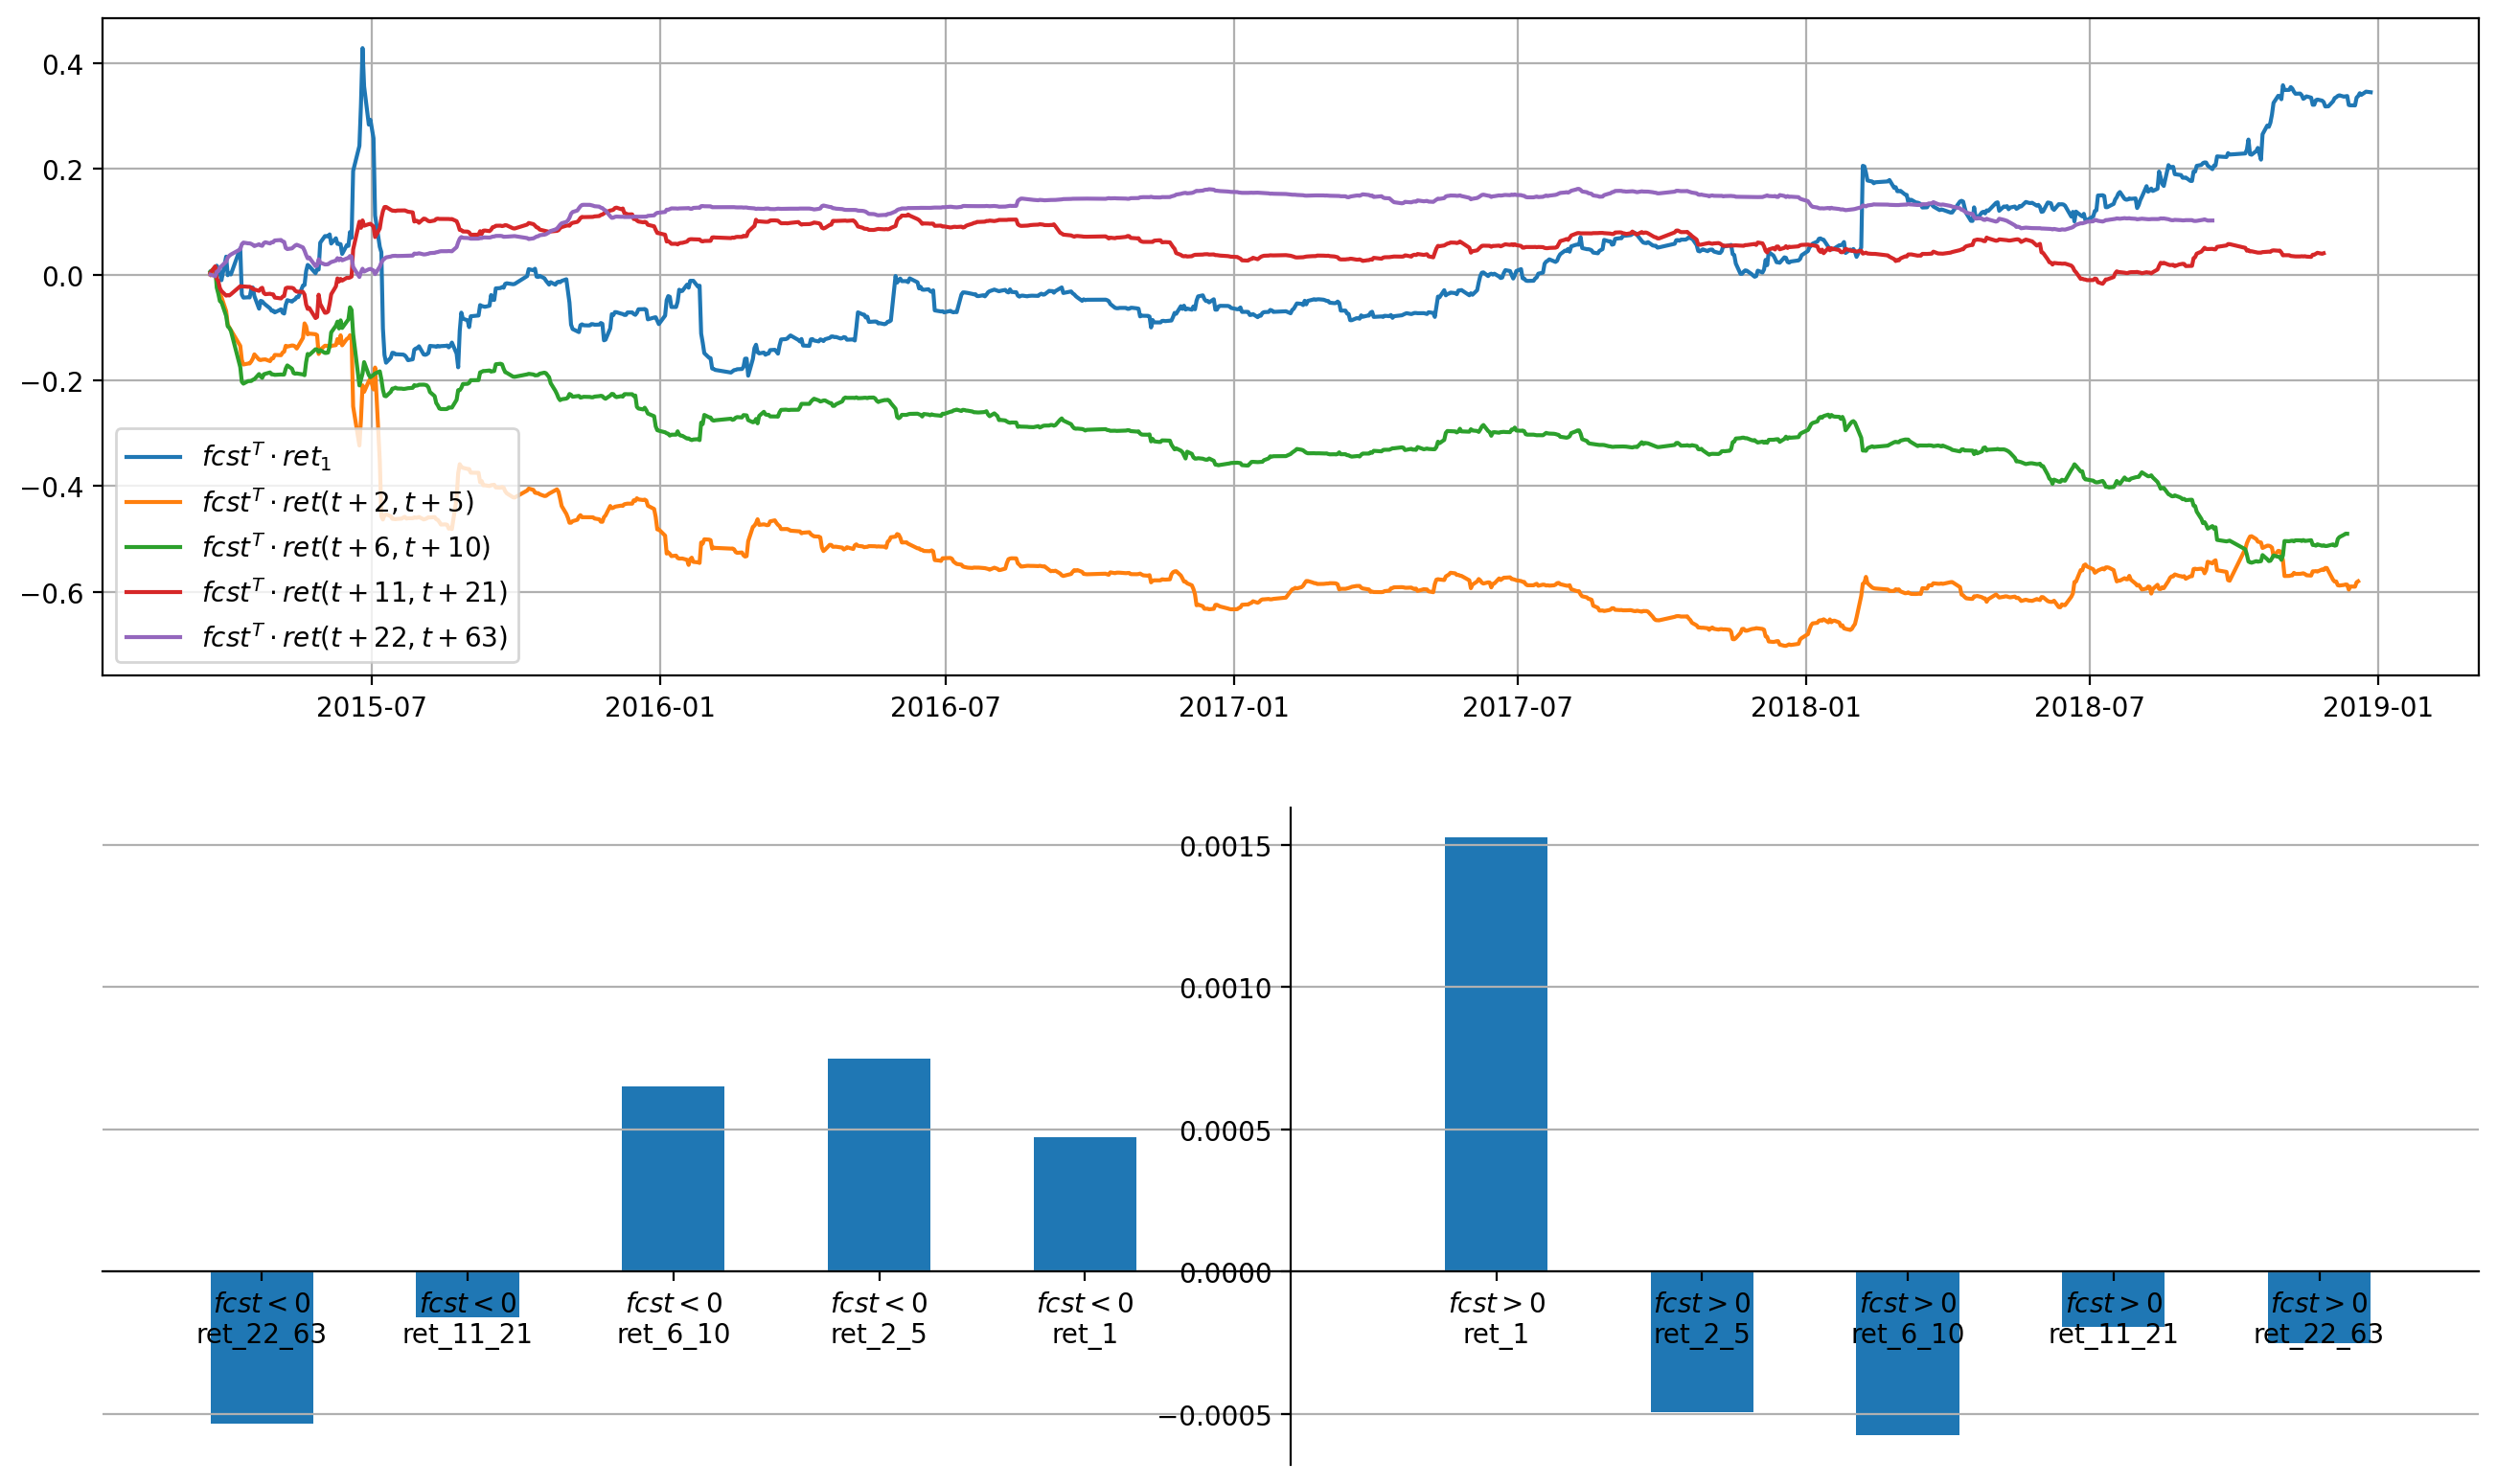

In [6]:
mt_model.dot_product_analysis()

## 与主要因子相关性

In [67]:
fcst

date
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
2015-01-09         NaN
                ...   
2022-04-26    0.484278
2022-04-27    0.973661
2022-04-28    0.092602
2022-04-29    0.962297
2022-05-05   -0.237289
Name: fcst, Length: 1726, dtype: float64

In [65]:

mtm = df['close'].pct_change(20)
mtm.name = 'mtm'
pd.DataFrame(fcst).join(mtm)
# stats.pearsonr(mtm, df['fcst'])

,fcst,mtm
date,,
2015-01-05,NaN,NaN
2015-01-06,NaN,NaN
2015-01-07,NaN,NaN
2015-01-08,NaN,NaN
2015-01-09,NaN,NaN
...,...,...
2022-04-26,0.484278,NaN
2022-04-27,0.973661,NaN
2022-04-28,0.092602,NaN


## 回测

In [38]:
north_cap_sgn = q.get_macro_data(
    macro_ids=["north_cap"], 
    start_date=BACKTEST_START_DATE, 
    end_date=BACKTEST_END_DATE
).set_index("data_date")["value_"]
north_cap_sgn.index.name = "date"

# 标准化输入信号
fcst = standard_scaler(north_cap_sgn)
fcst.name = "fcst"

# ADF检验
print(f"fcst's p-value = {sm.tsa.stattools.adfuller(fcst.dropna())[1]}")

bmk_daily = q.get_index_daily(BMK_ID, BACKTEST_START_DATE, BACKTEST_END_DATE)
bmk_daily.set_index("date", inplace=True)

df_bt = pd.DataFrame(fcst)
df_bt["open"], df_bt["close"] = bmk_daily["open"], bmk_daily["close"]

fcst's p-value = 4.14908622656396e-26



- 做多：$t$日触发$fcst_{t} > 1$时，对$t+1$日的股指进行做多操作（$pos_{t+1} = 1$），$t+2$日恢复平仓（$pos_{t+2} = 0$）
- 做空：$t$日触发$fcst_{t} < 1$时，对从$t+22$日到$t+63$日的股指开始进行做空操作（$pos = -1$），$t+64$日恢复平仓
- 做空操作期间，如果触发做多信号，则立即转为做多

股指隔夜涨跌幅
$$overnight\_ret_t = \frac{Open_t}{Close_{t-1}} - 1$$
股指白天涨跌幅
$$daytime\_ret_t = \frac{Close_t}{Open_{t}} - 1$$
因此$t$日的策略收益$stgy\_ret_t$由隔夜收益和白天收益两部分组成
$$stgy\_ret_t = (1 + pos_{t-1} \cdot overnight\_ret_t) (1 + pos_{t} \cdot daytime\_ret_t) - 1$$

In [41]:
dates_list = df_bt.index.tolist()
dates_len = len(dates_list)

df_bt["pos_long"] = df_bt["fcst"].shift(1).apply(lambda x: 1 if x>0 else 0) # 做多
df_bt["pos"] = df_bt["pos_long"]
for i, idx in enumerate(dates_list):
    fcst_i = df_bt.loc[idx, 'fcst']
    if fcst_i < 0:
        h = 40
        while (h <= 63) and (i+h <= dates_len-1) and (df_bt.loc[dates_list[i+h], 'pos'] == 1):
            df_bt.loc[dates_list[i+h], 'pos'] = -1
            h += 1

df_bt['overnight_ret'] = df_bt['open'] / df_bt['close'].shift(1) - 1
df_bt.loc[df_bt.index[0], 'overnight_ret'] = 0
df_bt['daytime_ret'] = df_bt['close'] / df_bt['open'] - 1
df_bt['stgy_ret'] = (1 + df_bt["pos"].shift(1) * df_bt['overnight_ret']) * (1 + df_bt["pos"] * df_bt['daytime_ret']) - 1
df_bt['stgy_long_ret'] = (1 + df_bt["pos_long"].shift(1) * df_bt['overnight_ret']) * (1 + df_bt["pos_long"] * df_bt['daytime_ret']) - 1
df_bt.loc[df_bt.index[0], 'stgy_ret'] = 0
df_bt.loc[df_bt.index[0], 'stgy_long_ret'] = 0
df_bt["stgy"] = (1 + df_bt["stgy_ret"]).cumprod() * df_bt.loc[BACKTEST_START_DATE, "close"]
df_bt["stgy_long"] = (1 + df_bt["stgy_long_ret"]).cumprod() * df_bt.loc[BACKTEST_START_DATE, "close"]

## 业绩评估

,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,0.09413,0.098939,0.216553,0.319228,-0.348433,0.270152
stgy,-0.137769,-0.177963,0.129871,-1.25332,-0.412706,-0.33382
stgy_long,0.133804,0.142716,0.131552,0.827079,-0.162343,0.824205


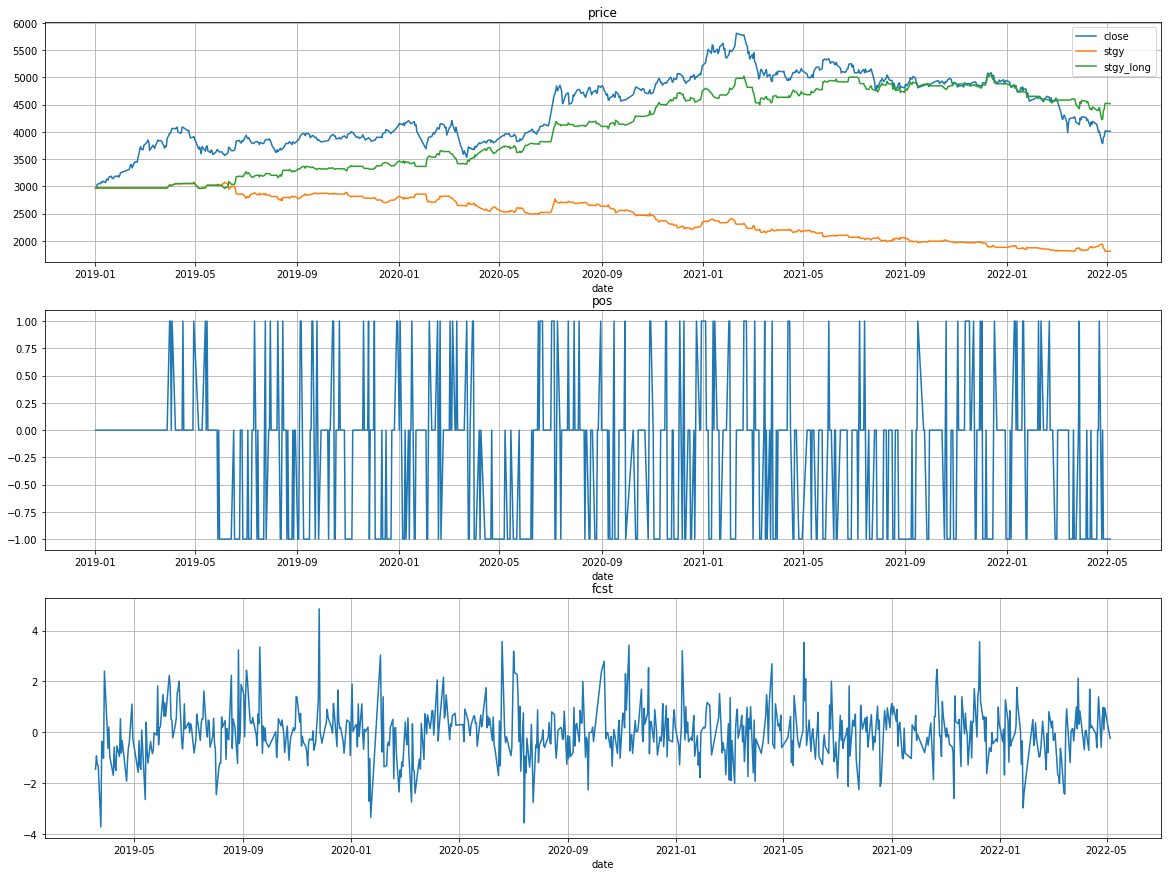

In [42]:
# 展示回测结果
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(3,1,1)
df_bt.loc[BACKTEST_START_DATE:, ['close', 'stgy', 'stgy_long']].plot(ax=ax1, grid=True, title='price')
ax2 = fig.add_subplot(3,1,2)
df_bt.loc[BACKTEST_START_DATE:, 'pos'].plot(ax=ax2, grid=True, title='pos')
ax3 = fig.add_subplot(3,1,3)
df_bt.loc[BACKTEST_START_DATE:, 'fcst'].plot(ax=ax3, grid=True, title='fcst')

cal_period_perf_indicator(df_bt.loc[BACKTEST_START_DATE:,['close', 'stgy', 'stgy_long']])

fcst's p-value = 0.0


,AnnRet,AnnRet_Simple,AnnVol,SR,MaxDD,Calmar
close,0.013236,0.017299,0.25041,-0.04698,-0.466961,0.028344
stgy,-0.114442,-0.156254,0.158195,-0.88146,-0.650353,-0.175969
stgy_long,0.098044,0.125223,0.16094,0.453859,-0.225158,0.435446


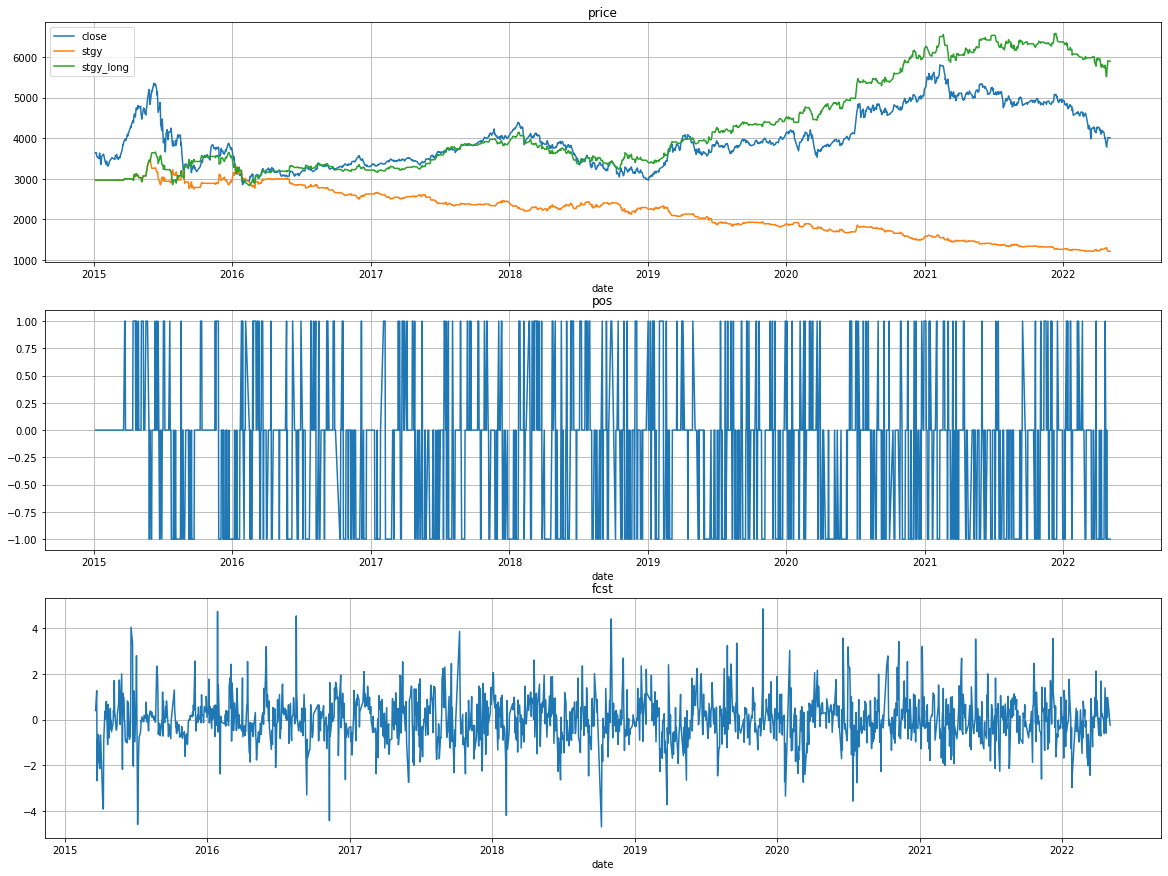

In [43]:
###############################

north_cap_sgn = q.get_macro_data(
    macro_ids=["north_cap"], 
    start_date=START_DATE, 
    end_date=BACKTEST_END_DATE
).set_index("data_date")["value_"]
north_cap_sgn.index.name = "date"

# 标准化输入信号
fcst = standard_scaler(north_cap_sgn)
fcst.name = "fcst"

# ADF检验
print(f"fcst's p-value = {sm.tsa.stattools.adfuller(fcst.dropna())[1]}")

bmk_daily = q.get_index_daily(BMK_ID, START_DATE, BACKTEST_END_DATE)
bmk_daily.set_index("date", inplace=True)

df_bt = pd.DataFrame(fcst)
df_bt["open"], df_bt["close"] = bmk_daily["open"], bmk_daily["close"]

dates_list = df_bt.index.tolist()
dates_len = len(dates_list)

df_bt["pos_long"] = df_bt["fcst"].shift(1).apply(lambda x: 1 if x>0 else 0) # 做多
df_bt["pos"] = df_bt["pos_long"]
for i, idx in enumerate(dates_list):
    fcst_i = df_bt.loc[idx, 'fcst']
    if fcst_i < 0:
        h = 40
        while (h <= 63) and (i+h <= dates_len-1) and (df_bt.loc[dates_list[i+h], 'pos'] == 1):
            df_bt.loc[dates_list[i+h], 'pos'] = -1
            h += 1

df_bt['overnight_ret'] = df_bt['open'] / df_bt['close'].shift(1) - 1
df_bt.loc[df_bt.index[0], 'overnight_ret'] = 0
df_bt['daytime_ret'] = df_bt['close'] / df_bt['open'] - 1
df_bt['stgy_ret'] = (1 + df_bt["pos"].shift(1) * df_bt['overnight_ret']) * (1 + df_bt["pos"] * df_bt['daytime_ret']) - 1
df_bt['stgy_long_ret'] = (1 + df_bt["pos_long"].shift(1) * df_bt['overnight_ret']) * (1 + df_bt["pos_long"] * df_bt['daytime_ret']) - 1
df_bt.loc[df_bt.index[0], 'stgy_ret'] = 0
df_bt.loc[df_bt.index[0], 'stgy_long_ret'] = 0
df_bt["stgy"] = (1 + df_bt["stgy_ret"]).cumprod() * df_bt.loc[BACKTEST_START_DATE, "close"]
df_bt["stgy_long"] = (1 + df_bt["stgy_long_ret"]).cumprod() * df_bt.loc[BACKTEST_START_DATE, "close"]

# 展示回测结果
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(3,1,1)
df_bt.loc[START_DATE:, ['close', 'stgy', 'stgy_long']].plot(ax=ax1, grid=True, title='price')
ax2 = fig.add_subplot(3,1,2)
df_bt.loc[START_DATE:, 'pos'].plot(ax=ax2, grid=True, title='pos')
ax3 = fig.add_subplot(3,1,3)
df_bt.loc[START_DATE:, 'fcst'].plot(ax=ax3, grid=True, title='fcst')

cal_period_perf_indicator(df_bt.loc[START_DATE:,['close', 'stgy', 'stgy_long']])

## 胜率评估

In [35]:
# 做多/空日期
short_dates = df_bt[df_bt["pos"] == -1].index.to_list()
long_dates = df_bt[df_bt["pos"] == 1].index.to_list()

print("总胜率：", (df_bt.loc[short_dates+long_dates, "stgy_ret"] > 0).sum() / len(short_dates+long_dates))
print("看空胜率：", (df_bt.loc[short_dates, "stgy_ret"] > 0).sum() / len(short_dates))
print("看多胜率：", (df_bt.loc[long_dates, "stgy_ret"] > 0).sum() / len(long_dates))

总胜率： 0.47330960854092524
看空胜率： 0.4469964664310954
看多胜率： 0.5270758122743683


In [ ]:
盈亏比
盈亏分布曲线
收益率周月度效益分布（+节假日前后）
换手率
主要因子相关性（动量因子-过去20）
指数 线性回归 alpha beta


两套策略 
 - 每天调仓
- 